In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# from google.colab import files

In [5]:
import numpy as np
import pandas as pd


In [6]:
import tensorflow as tf

In [7]:
text_file = tf.keras.utils.get_file(
    fname = 'fra-eng.zip',
    origin = 'http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract = True
)

3423204/3423204 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
text_file

'/root/.keras/datasets/fra-eng_extracted'

In [9]:
import pathlib

In [10]:
# text_file = pathlib.Path(text_file).parent / "fra.txt"  # extracted folder
text_file = pathlib.Path('/root/.keras/datasets/fra-eng_extracted/') / "fra.txt" # correct path

In [11]:
print(text_file)

/root/.keras/datasets/fra-eng_extracted/fra.txt


In [12]:
import os
print(os.listdir('/root/.keras/datasets/'))

['fra-eng.zip', 'fra-eng_extracted']


In [13]:
with open(text_file) as fp:
  text_pair = [line.strip() for line in fp]

In [14]:
import random
for _ in range(5):
  print(random.choice(text_pair))

She was robbed of her purse.	Son sac à main lui a été dérobé.
Write down your name here.	Écrivez votre nom ici.
I thought you'd ask about that.	Je pensais que tu poserais des questions concernant cela.
What time does your plane leave?	À quelle heure part ton avion ?
The rain is wonderful.	La pluie est merveilleuse.


In [15]:
import unicodedata
import re

def normalize(line):
  line = unicodedata.normalize('NFKC', line.strip().lower())
  line = re.sub(r"^([^ \w])(?!\s)",r"\1",line)
  line = re.sub(r"(\s[^ \w])(?!\s)",r"\1",line)
  line = re.sub(r"(?!\s)([^ \w])$",r"\1",line)
  line = re.sub(r"(?!\s)([^ \w]\s)",r"\1",line)
  eng,fre = line.split("\t")
  fre = '[start]' + fre + '[end]'
  return eng,fre

In [16]:
with open(text_file) as fp:
  text_pair = [normalize(line) for line in fp]

In [17]:
for _ in range(5):
  print(random.choice(text_pair))

('maybe we should cancel the meeting.', '[start]peut-être devrions-nous annuler la réunion.[end]')
('tom met mary on the way to school.', "[start]tom a rencontré mary en allant à l'école.[end]")
('she picked up a stone.', '[start]elle ramassa une pierre.[end]')
('we all have jobs to do.', '[start]nous avons tous des boulots à effectuer.[end]')
("i should've warned you.", "[start]j'aurais dû vous prévenir.[end]")


In [18]:
eng_tokens,fre_tokens = set(),set()
eng_maxlen,fre_maxlen = 0,0
for eng,fre in text_pair:
  eng_token, fre_token = eng.split(),fre.split()
  eng_maxlen = max(eng_maxlen,len(eng.split()))
  fre_maxlen = max(fre_maxlen,len(fre.split()))
  eng_tokens.update(eng_token)
  fre_tokens.update(fre_token)

print("total english token: ",len(eng_tokens))
print("total french token: ",len(fre_tokens))
print("max english length: ",eng_maxlen)
print("max french length: ",fre_maxlen)

total english token:  25365
total french token:  44581
max english length:  47
max french length:  54


In [19]:
import pickle
with open("text_pairs.pickle",'wb') as fp:
    pickle.dump(text_pair,fp)

In [20]:
from tensorflow.keras.layers import TextVectorization

import pickle

with open("text_pairs.pickle",'rb') as fp:
  text_pairs = pickle.load(fp)

In [21]:
random.shuffle(text_pairs)

In [22]:
n_val = int(0.15 * len(text_pairs))
n_train = len(text_pairs) - 2 * n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train: n_train + n_val]

In [23]:
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

In [24]:
eng_vect = TextVectorization(
    max_tokens = vocab_en,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [25]:
fr_vect = TextVectorization(
    max_tokens = vocab_fr,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [26]:
train_eng = [pair[0] for pair in train_pair]
train_fr = [pair[1] for pair in train_pair]

In [27]:
eng_vect.adapt(train_eng)
fr_vect.adapt(train_fr)

In [28]:
with open('vectorizer.pickle','wb') as fp:
  data = {
      'train' : train_pair,
      'test' : test_pair,
      'eng_vect' : eng_vect.get_config(),
      'fr_vect' : fr_vect.get_config(),
      'eng_weight' : eng_vect.get_weights(),
      'fr_weight' : fr_vect.get_weights(),
  }
  pickle.dump(data,fp)

In [29]:
with open('vectorizer.pickle','rb') as fp:
  data = pickle.load(fp)

In [30]:
train_pair = data['train']
test_pair = data['test']

eng_vect = TextVectorization.from_config(data['eng_vect'])
eng_vect.set_weights(data['eng_weight'])
fr_vect = TextVectorization.from_config(data['fr_vect'])
fr_vect.set_weights(data['fr_weight'])

# Re-adapt the vectorization layers after loading
train_eng = [pair[0] for pair in train_pair]
train_fr = [pair[1] for pair in train_pair]
eng_vect.adapt(train_eng)
fr_vect.adapt(train_fr)

In [31]:
def format_dataset(eng,fr):

  eng = eng_vect(eng)
  fr = fr_vect(fr)

  source = {
      'encode_inp' : eng,
      'decode_inp' : fr[:,:] # Modified to include the last element
  }

  target = fr[:,:] # Modified to include the last element

  return (source,target)


def make_dataset(pairs,batchsize = 64):

  eng_text,fr_text = zip(*pairs)
  dataset = tf.data.Dataset.from_tensor_slices((list(eng_text),list(fr_text)))

  return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16).cache()

In [32]:
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)

In [33]:
train_ds

<CacheDataset element_spec=({'encode_inp': TensorSpec(shape=(None, 25), dtype=tf.int64, name=None), 'decode_inp': TensorSpec(shape=(None, 25), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 25), dtype=tf.int64, name=None))>

In [34]:
for inputs,target in train_ds.take(1):
  print(inputs['encode_inp'].shape)
  print(inputs['encode_inp'][0])
  print(inputs['decode_inp'].shape)
  print(inputs['decode_inp'][0])
  print(target.shape)
  print(target[0])

(64, 25)
tf.Tensor(
[  94   11    3   52   22 1716  906    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[ 148    1  223 1831    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[ 148    1  223 1831    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


Positional embedding

In [35]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L,d,n=10000):

  assert d%2 == 0
  d2 = d//2

  P = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1,-1)

  denom = np.power(n,-i/d2)
  args = k*denom

  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)

  return P

In [36]:
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self,seq_length,vocab_size,embed_dim,**kwargs):
    super().__init__(**kwargs)
    self.seq_length = seq_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

    self.token_embeddings = tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = embed_dim,
        mask_zero = True
    )
    matrix = pos_enc_matrix(seq_length,embed_dim)
    self.positional_encoding_matrix = tf.constant(matrix,dtype = 'float32')



  def call(self,inputs):
    embedded_tokens = self.token_embeddings(inputs)
    # Add positional encoding to token embeddings - removed incorrect slicing
    return embedded_tokens + self.positional_encoding_matrix


  def compute_mask(self,*args,**kwargs):
    return self.token_embeddings.compute_mask(*args,**kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        'seq_length' : self.seq_length,
        'vocab_size' : self.vocab_size,
        'embed_dim' : self.embed_dim
    })
    return config

In [37]:
vocab_en = 10000
# vocab_fr = 20000
seq_length = 25

In [38]:
for inputs,targets in train_ds.take(1):
  print(inputs['encode_inp'])
  embed_en = PositionalEmbedding(seq_length,vocab_en,embed_dim = 512)

  en_emb = embed_en(inputs['encode_inp'])
  print(embed_en.compute_mask(inputs['encode_inp'])) # Corrected to call compute_mask

tf.Tensor(
[[   9  126   28 ...    0    0    0]
 [   2  258    2 ...    0    0    0]
 [   9 1069 1543 ...    0    0    0]
 ...
 [ 833  135   15 ...    0    0    0]
 [   2  199  305 ...    0    0    0]
 [ 218  159   92 ...    0    0    0]], shape=(64, 25), dtype=int64)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 25), dtype=bool)


Nural Networks

In [39]:
def self_attention(input_shape,prfix = 'att' , mask = False, **kwargs):
  inputs = tf.keras.layers.Input(shape = input_shape,dtype = 'float32',name = f"{prfix}_in1")
  attention = tf.keras.layers.MultiHeadAttention(name = f'{prfix}_att1',**kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f'{prfix}_norm1')
  add = tf.keras.layers.Add(name = f'{prfix}_add1')

  attout = attention(query = inputs, value = inputs, key = inputs, use_causal_mask = mask)

  output = norm(add([inputs,attout]))

  model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prfix}_att")

  return model

In [40]:
seq_length = 25
key_dim = 128
num_heads = 8

model = self_attention(input_shape = (seq_length,key_dim), num_heads = num_heads,key_dim = key_dim)


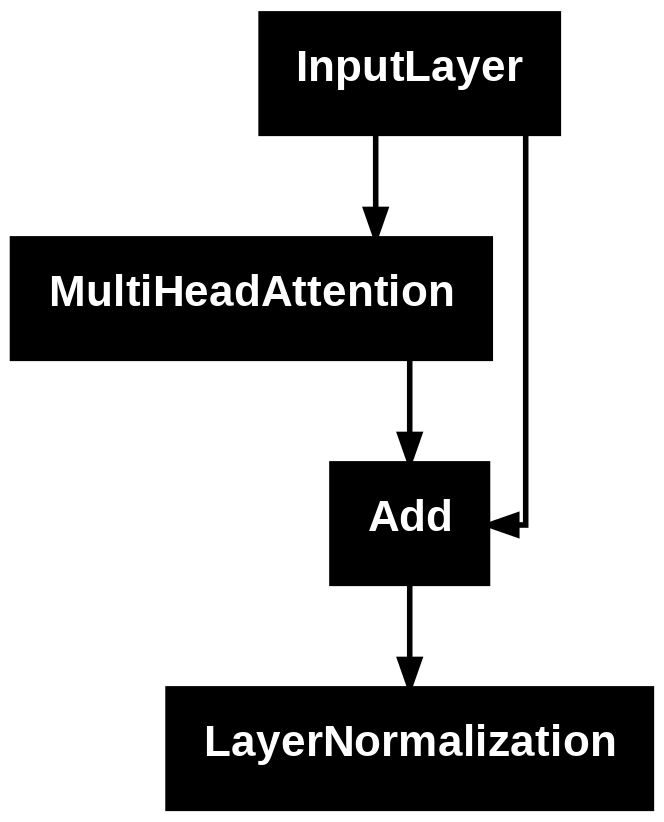

In [41]:
tf.keras.utils.plot_model(model)

In [42]:
def cross_attention(input_shape,context_shape, prfix = 'att' ,**kwargs):
  context = tf.keras.layers.Input(shape = context_shape,dtype = 'float32',name = f"{prfix}_in1")
  inputs = tf.keras.layers.Input(shape = input_shape,dtype = 'float32',name = f"{prfix}_ctx2")
  attention = tf.keras.layers.MultiHeadAttention(name = f"{prfix}_att2",**kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f"{prfix}_norm2")
  add = tf.keras.layers.Add(name = f"{prfix}_add2")

  attout = attention(query = inputs, value = context, key = context)

  output = norm(add([inputs,attout]))

  model = tf.keras.Model(inputs = [context,inputs], outputs = output, name = f"{prfix}_cross")

  return model


In [43]:
model = cross_attention(input_shape = (seq_length,key_dim),context_shape = (seq_length,key_dim),num_heads = num_heads,key_dim = key_dim)

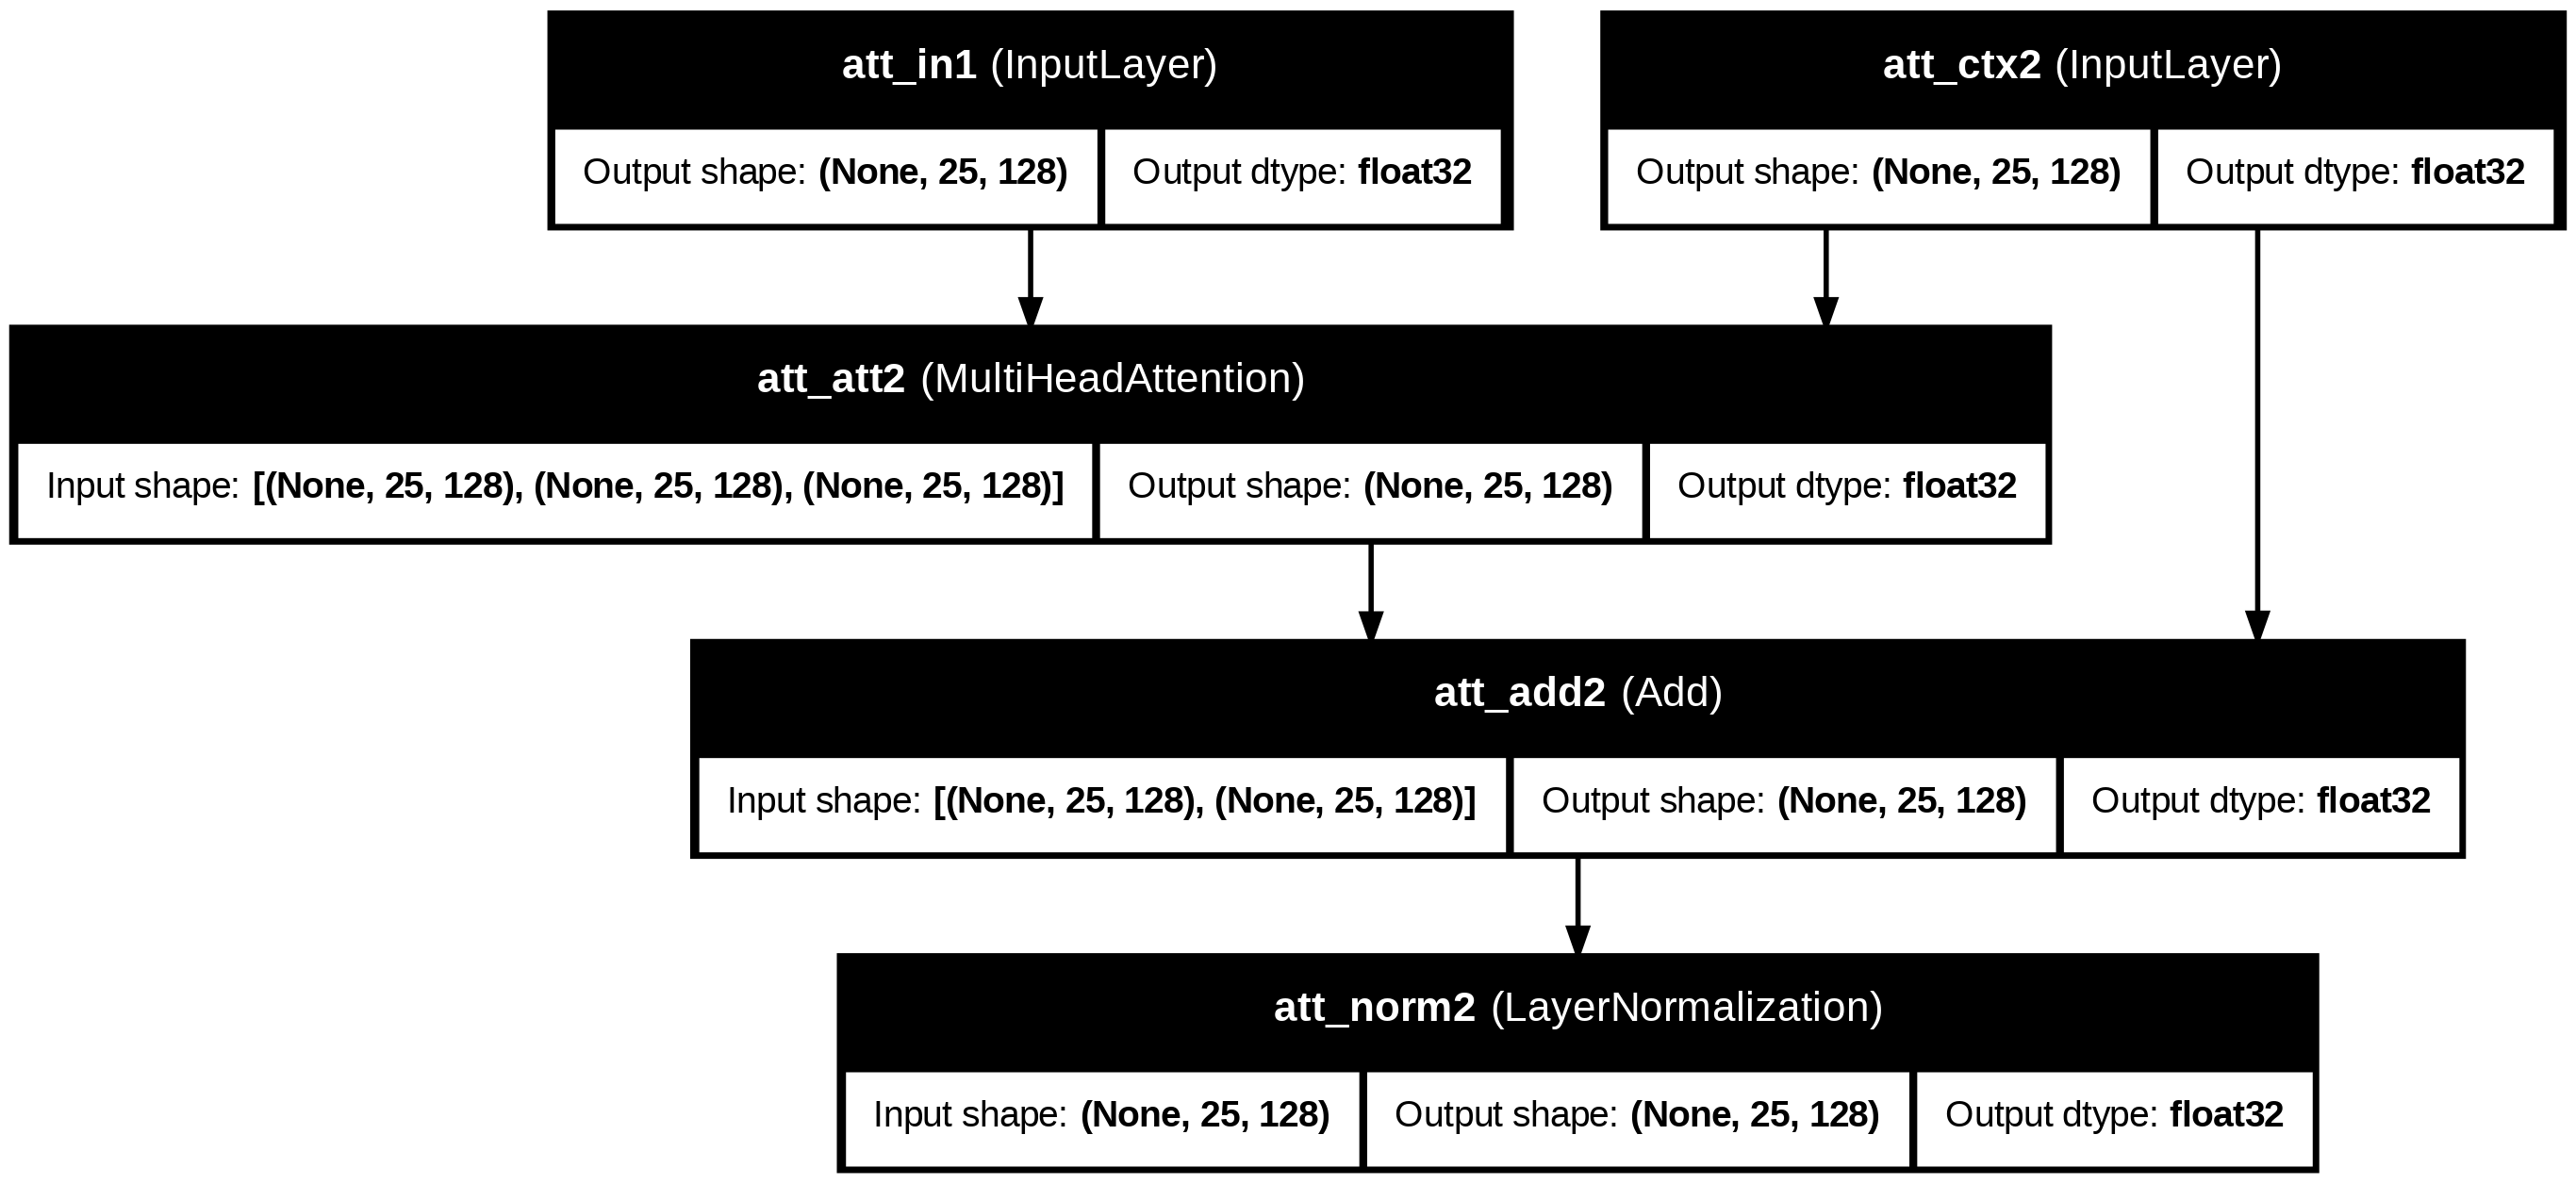

In [44]:
tf.keras.utils.plot_model(model, show_shapes = True,show_dtype = True, show_layer_names = True, show_layer_activations = True)

In [45]:
def feed_forward(input_shape,model_dim,ff_dim,droupout = .1, prfix = 'ff'):

  inputs = tf.keras.layers.Input(shape = input_shape,dtype = 'float32',name = f"{prfix}_in3")
  dense1 = tf.keras.layers.Dense(ff_dim,name = f"{prfix}_ff1",activation = 'relu')
  dense2 = tf.keras.layers.Dense(model_dim,name = f"{prfix}_ff2")
  drop = tf.keras.layers.Dropout(droupout,name = f"{prfix}_drop")
  add = tf.keras.layers.Add(name = f"{prfix}_add3")

  ffout = drop(dense2(dense1(inputs)))

  norm = tf.keras.layers.LayerNormalization(name = f"{prfix}_norm3")
  output = norm(add([inputs,ffout]))

  model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prfix}_ff")

  return model

In [46]:

ff_dim = 512

model = feed_forward(input_shape = (seq_length,key_dim),model_dim = key_dim,ff_dim = ff_dim)

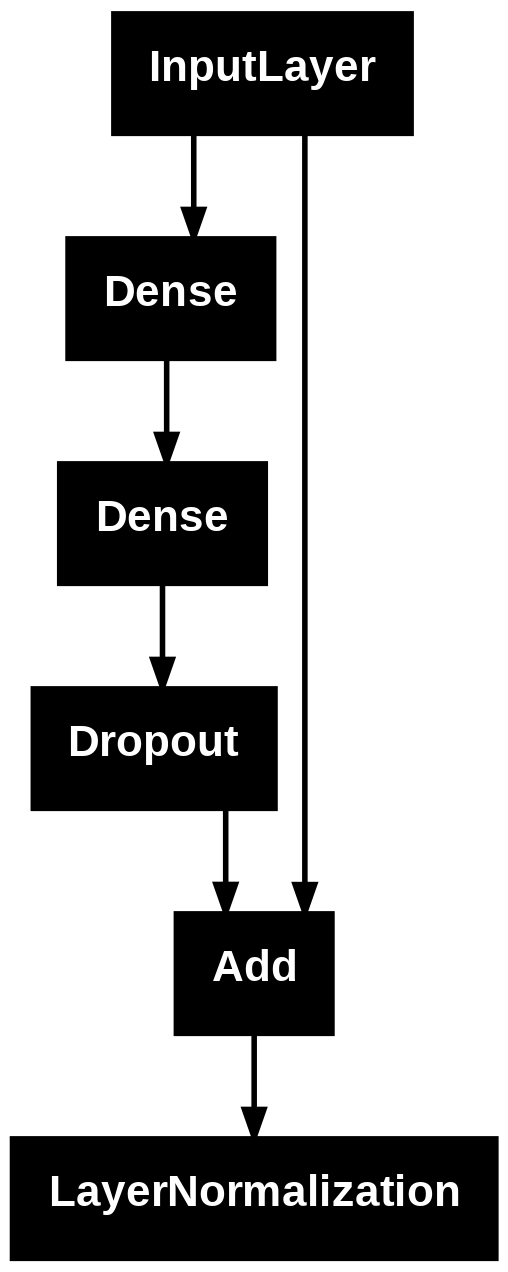

In [47]:
tf.keras.utils.plot_model(model)

Encoder and Decoder

In [48]:
import tensorflow as tf

def encoder(input_shape,key_dim,ff_dim,dropout = .1, prefix = 'enc',**kwargs):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = input_shape,dtype = 'float32',name = f'{prefix}_in0'),
      self_attention(input_shape,prfix = prefix ,key_dim = key_dim, mask = False,**kwargs),
      feed_forward(input_shape,key_dim,ff_dim,dropout,prefix)
  ])

  return model

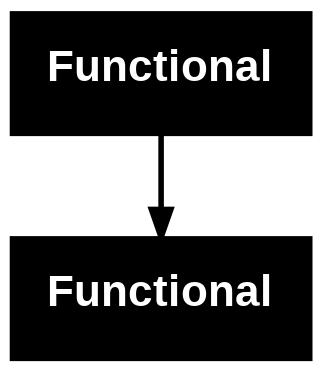

In [49]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape = (seq_length,key_dim),key_dim = key_dim,ff_dim = ff_dim,num_heads = num_heads)
tf.keras.utils.plot_model(model)


Decoder

In [50]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='dec', **kwargs):
    # Define inputs for decoder
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0')
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_ctx0')

    # Self-attention and cross-attention layers
    att_model = self_attention(input_shape, key_dim=key_dim, mask=True, prfix=prefix, **kwargs)
    cross_model = cross_attention(input_shape, input_shape, key_dim=key_dim, prfix=prefix, **kwargs)

    # Feed-forward layer
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    # Connect layers
    x = att_model(inputs)
    x = cross_model([context, x])
    output = ff_model(x)

    # Define decoder model
    model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)

    return model

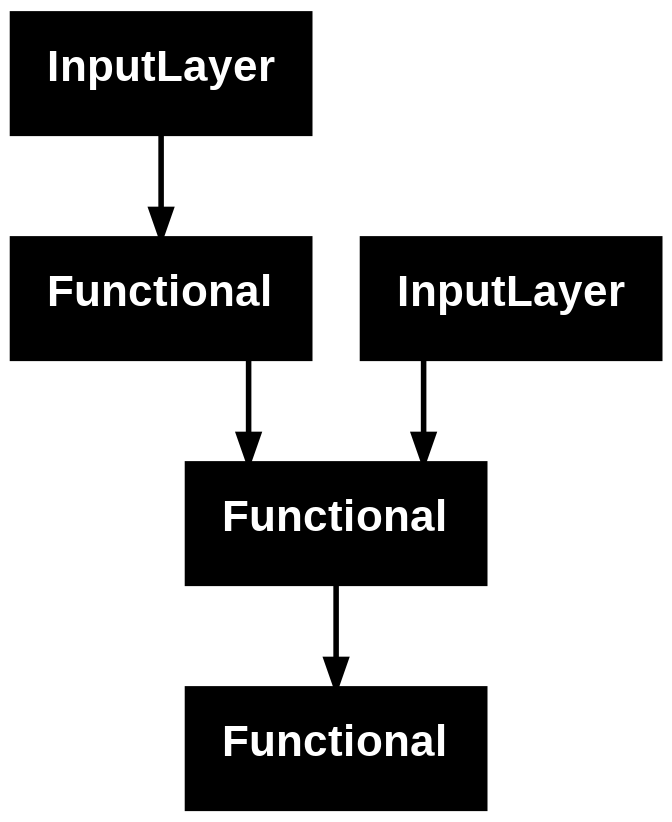

In [51]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape = (seq_length,key_dim),key_dim = key_dim,ff_dim = ff_dim,num_heads = num_heads)
tf.keras.utils.plot_model(model)

Transformer Model

In [52]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout=0.1, name='transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape=(seq_length,), dtype='float32', name='encode_inp')
    input_dec = tf.keras.layers.Input(shape=(seq_length,), dtype='float32', name='decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name='embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name='embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

    # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


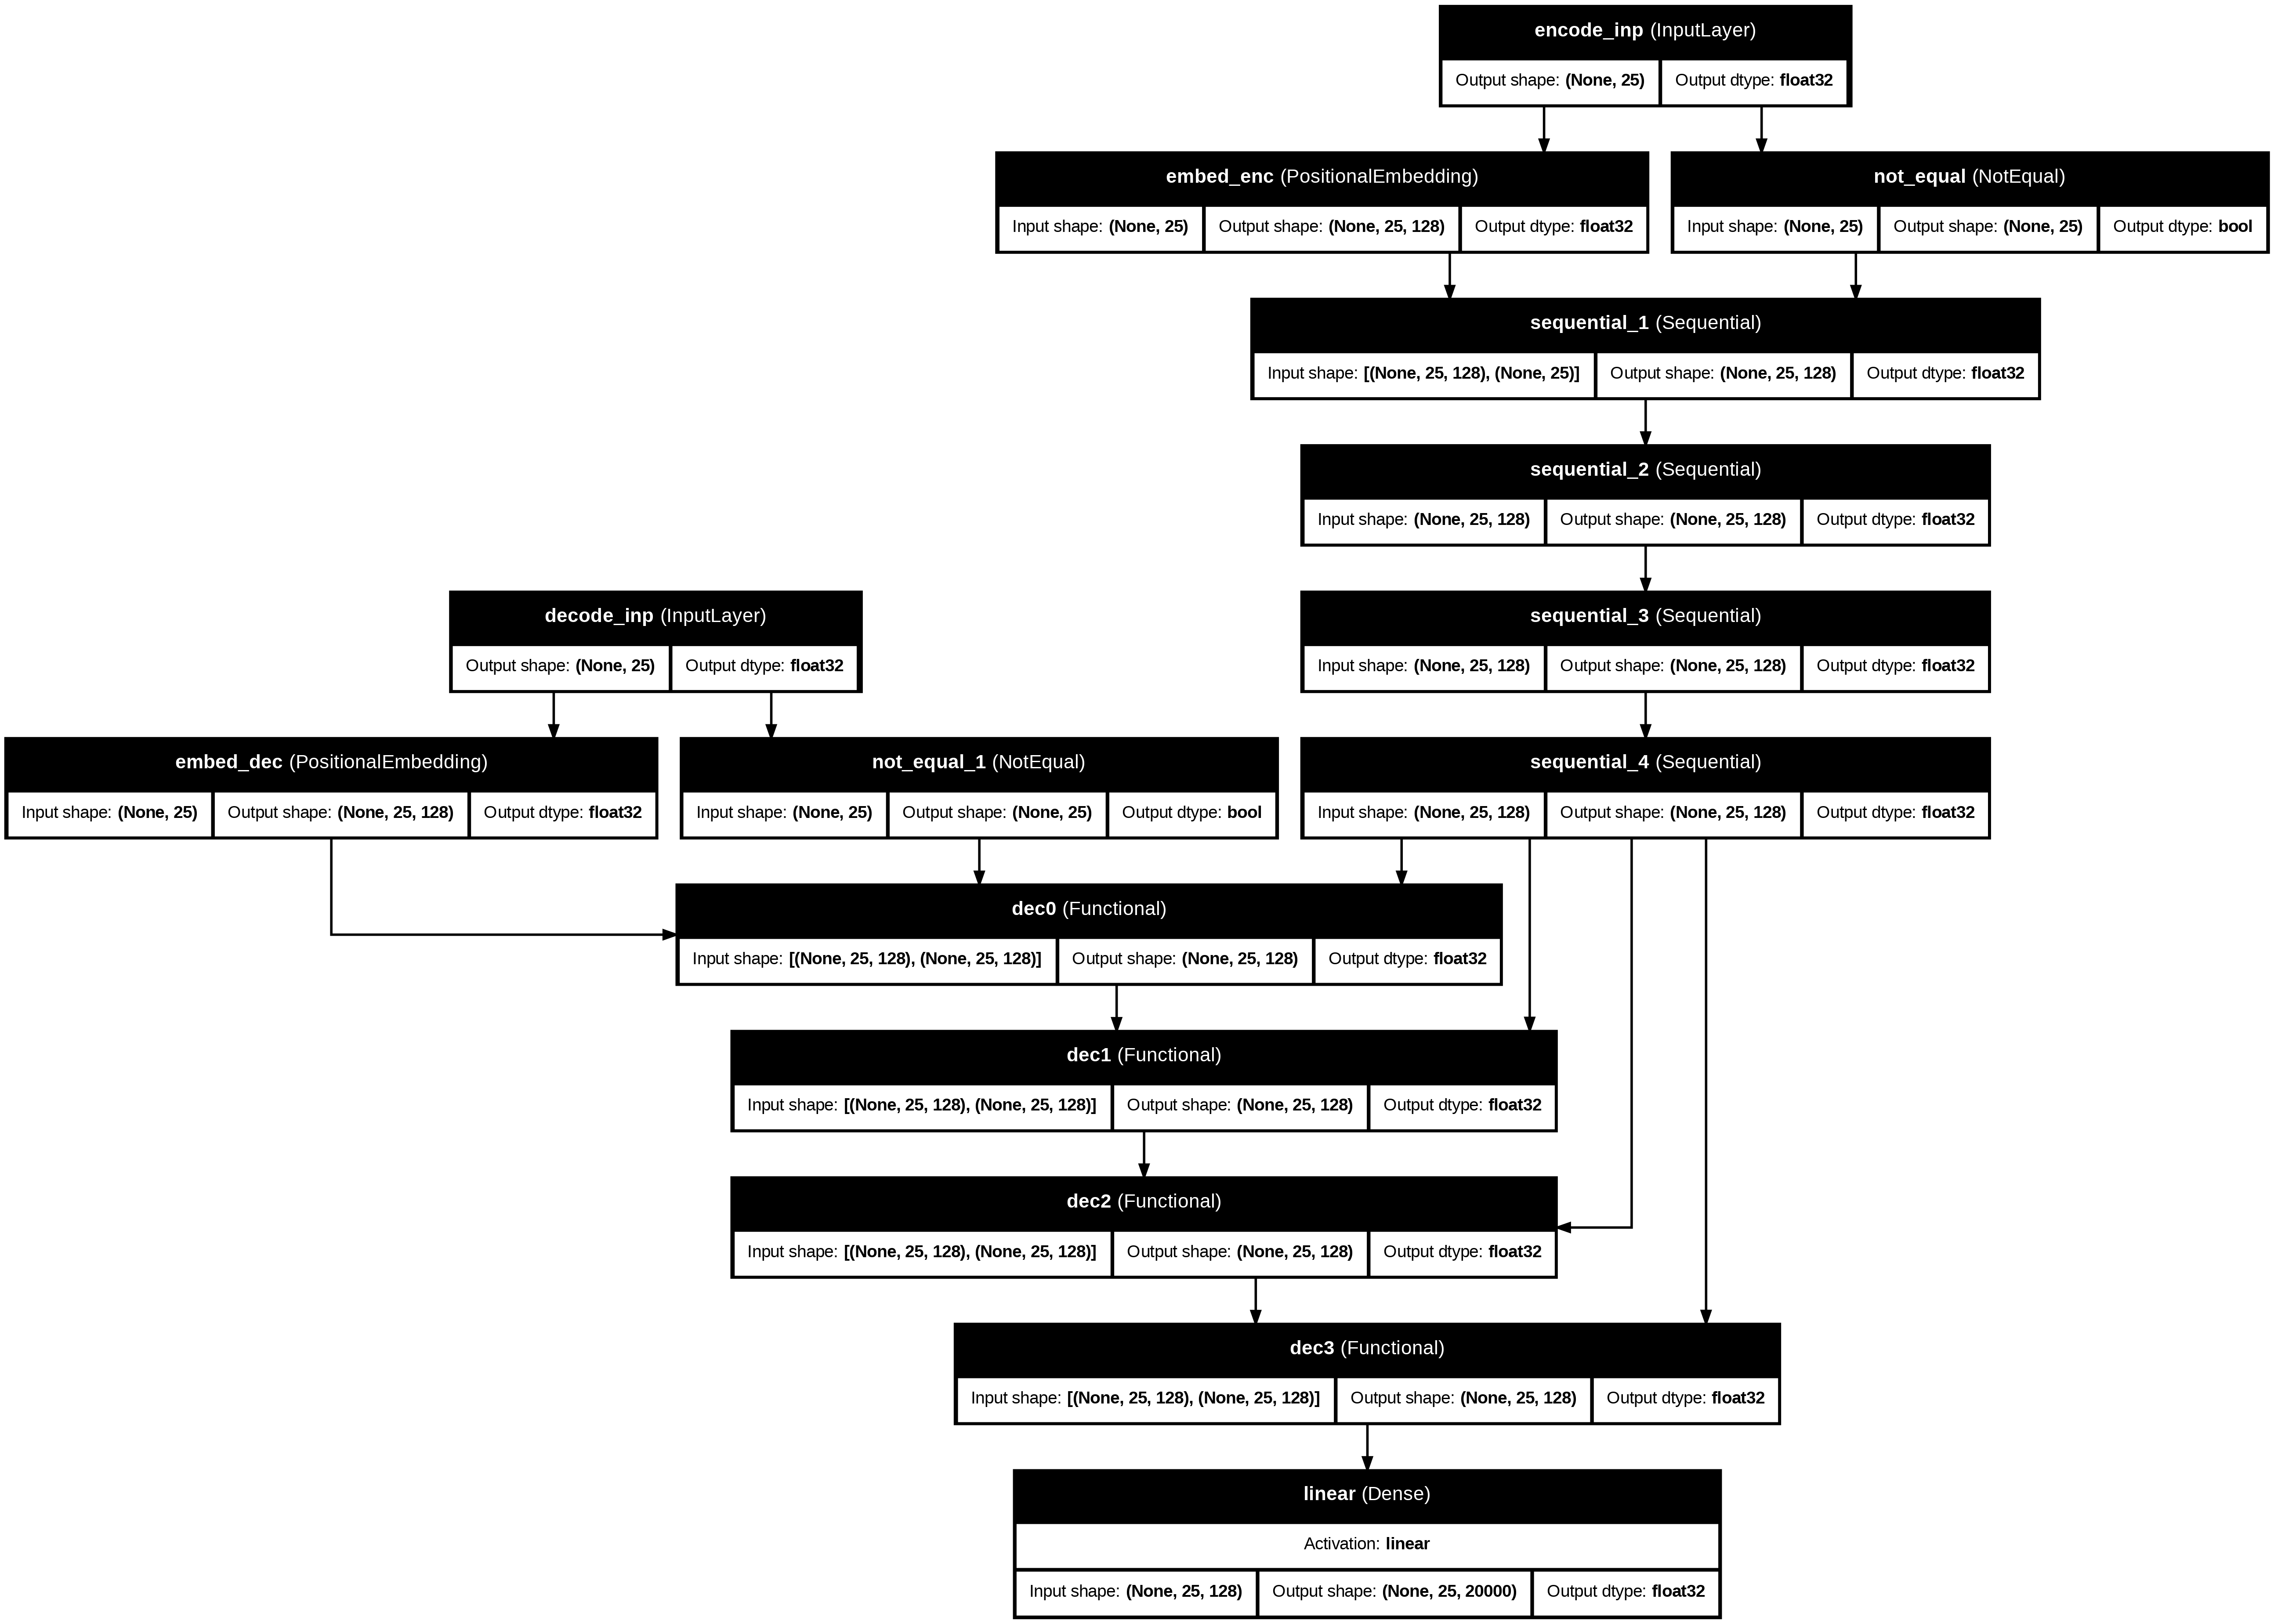

In [53]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = .1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr,dropout)

tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True,show_layer_activations = True)

In [54]:
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(train_ds,epochs = 20,validation_data = test_ds)

In [56]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps=40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    # Convert step to float32
    step = tf.cast(step, dtype=tf.float32)
    # Calculate learning rate schedule
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [57]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

# Masked Accuracy Metric

def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [58]:
# Compile the model with custom loss and metrics
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])
model.summary()




Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 199s 86ms/step - loss: 9.5947 - mask_accuracy: 0.0426 - val_loss: 7.5643 - val_mask_accuracy: 0.2378
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 149s 81ms/step - loss: 6.8355 - mask_accuracy: 0.2630 - val_loss: 4.0124 - val_mask_accuracy: 0.5084
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 206s 84ms/step - loss: 3.5550 - mask_accuracy: 0.5663 - val_loss: 2.0319 - val_mask_accuracy: 0.7654
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 148s 81ms/step - loss: 1.9581 - mask_accuracy: 0.7806 - val_loss: 1.2236 - val_mask_accuracy: 0.8849
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 152s 83ms/step - loss: 1.2454 - mask_accuracy: 0.8816 - val_loss: 0.8242 - val_mask_accuracy: 0.9306
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 152s 83ms/step - loss: 0.8793 - mask_accuracy: 0.9220 - val_loss: 0.6163 - val_mask_accuracy: 0.9446
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 148s 81ms/step - loss: 0.6730 - mask_accuracy: 0.9367 - val_loss: 0.5027 - val_mask_accuracy: 0.9530
Epoch 8/20

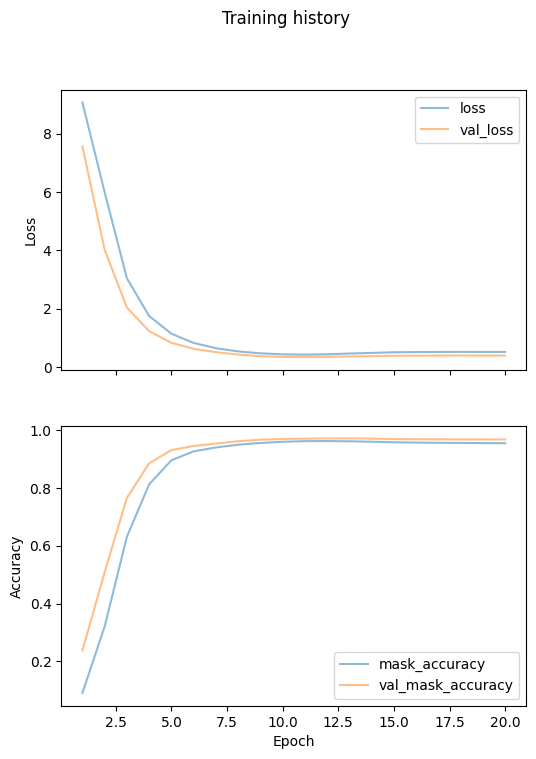

In [62]:
import matplotlib.pyplot as plt

# Visualizing Training History
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, 21))  # Assuming 20 epochs
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["mask_accuracy"], alpha=0.5, label="mask_accuracy")
axs[1].plot(x, history.history["val_mask_accuracy"], alpha=0.5, label="val_mask_accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower right")
plt.show()

In [75]:
def translate(sentence):
    # Encode input sentence
    enc_tokens = eng_vect([sentence])
    lookup = list(fr_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]
    for i in range(seq_length):
        # Prepare decoder input
        vector = fr_vect([" ".join(output_sent)])
        assert vector.shape == (1, seq_length)
        dec_tokens = vector[:, :]
        assert dec_tokens.shape == (1, seq_length)
        # Generate predictions
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_length, vocab_size_fr)
        # Decode predicted token
        word = lookup[np.argmax(pred[0, i, :])]
        output_sent.append(word)
        if word == end_sent:
            break
    return output_sent


In [76]:
seq_length = 25
vocab_size_en = 10000
vocab_size_fr = 20000
test_count = 20

# Test the model on sample test cases
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pair)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist

Test case: 0
English sentence: don't waste your time trying to convince tom.
Translated sentence: [start] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
French sentence: [start]ne perdez pas votre temps à essayer de convaincre tom.[end]

Test case: 1
English sentence: sure, it might be traumatic, but so what?
Translated sentence: [start] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
French sentence: [start]certes, c'est peut-être traumatique, mais qu'est-ce qu'on y peut?[end]

Test case: 2
English sentence: he cooked me dinner.
Translated sentence: [start] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
French sentence: [start]il m'a préparé à déjeuner.[end]

Test case: 3
English se